In [37]:
import math
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
pd.options.mode.chained_assignment = None

In [74]:
acao = "PETR4.SA"

inicio = "2010-12-31"
final = "2024-04-30"

dados_acao = yf.download(acao, start=inicio, end=final)

dados_acao

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,27.500000,27.580000,26.910000,27.000000,7.711923,22738500
2011-01-04,27.010000,27.059999,26.400000,26.900000,7.683362,30936600
2011-01-05,26.680000,27.350000,26.580000,27.219999,7.774759,24306800
2011-01-06,27.200001,27.459999,27.010000,27.110001,7.743344,24328800
2011-01-07,27.020000,27.180000,26.730000,26.730000,7.634805,17453800
...,...,...,...,...,...,...
2024-04-23,41.400002,41.630001,40.959999,41.419998,37.526100,35456900
2024-04-24,41.549999,41.990002,41.209999,41.230000,37.353962,45388300
2024-04-25,41.400002,42.480000,41.080002,42.220001,38.250893,66372400


In [75]:
# não pode ser ajustados
cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

cotacao

array([[27.        ],
       [26.89999962],
       [27.21999931],
       ...,
       [42.22000122],
       [41.65000153],
       [42.15000153]])

In [76]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

2646

In [77]:
# Escalar os dados entre 0 e 1, para deixar mais facil o precessamento
# Dados em escola pré definidos são masi faceis de lidar

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_1_trei = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_1 = list(dados_entre_0_1_trei.reshape(len(dados_entre_0_1_trei))) + list(dados_entre_0_1_teste.reshape(len(dados_entre_0_1_teste)))

dados_entre_0_1 = np.array(dados_entre_0_1).reshape(len(dados_entre_0_1), 1)

dados_entre_0_1

array([[0.84695391],
       [0.84323919],
       [0.85512625],
       ...,
       [1.41233284],
       [1.391159  ],
       [1.40973255]])

In [78]:
dados_para_treinamento = dados_entre_0_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []

#cotação que aconteceu de fato
treinamento_y = []

for i in range(60, len(dados_para_treinamento)):

    #ultimos 60 dias
    treinamento_x.append(dados_para_treinamento[i -60: i, 0])
    #cotação
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)

[array([0.84695391, 0.84323919, 0.85512625, 0.85104012, 0.83692418,
       0.84621095, 0.85252596, 0.88038629, 0.85846949, 0.86738479,
       0.86367014, 0.8736998 , 0.85809801, 0.85698365, 0.84881124,
       0.84695391, 0.8406389 , 0.84212482, 0.83469537, 0.85029716,
       0.87072803, 0.87667156, 0.88521545, 0.86998515, 0.85512625,
       0.84249623, 0.84249623, 0.84249623, 0.82466564, 0.83766714,
       0.84583947, 0.85846949, 0.85624069, 0.86069837, 0.86181274,
       0.8755572 , 0.91047542, 0.91047542, 0.90638929, 0.90564633,
       0.89487371, 0.91753339, 0.9197622 , 0.92421988, 0.92421988,
       0.8885587 , 0.89041602, 0.89450223, 0.88558693, 0.87592868,
       0.88707278, 0.88038629, 0.88893011, 0.88893011, 0.88893011,
       0.90007428, 0.90007428, 0.89710251, 0.89710251, 0.89710251])]
[0.8978454719619584]
[array([0.84695391, 0.84323919, 0.85512625, 0.85104012, 0.83692418,
       0.84621095, 0.85252596, 0.88038629, 0.85846949, 0.86738479,
       0.86367014, 0.8736998 , 0.8580

In [79]:
#tranformando as listas em arrays e dando reshape 3d
treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0] , treinamento_x.shape[1], 1)

treinamento_x

[[0.84695391 0.84323919 0.85512625 ... 0.89710251 0.89710251 0.89710251]
 [0.84323919 0.85512625 0.85104012 ... 0.89710251 0.89710251 0.89784547]
 [0.85512625 0.85104012 0.83692418 ... 0.89710251 0.89784547 0.89784547]
 ...
 [0.87927192 0.90267456 0.89487371 ... 0.86849923 0.87407128 0.86515598]
 [0.90267456 0.89487371 0.90861809 ... 0.87407128 0.86515598 0.90230308]
 [0.89487371 0.90861809 0.90861809 ... 0.86515598 0.90230308 0.89524512]]


array([[[0.84695391],
        [0.84323919],
        [0.85512625],
        ...,
        [0.89710251],
        [0.89710251],
        [0.89710251]],

       [[0.84323919],
        [0.85512625],
        [0.85104012],
        ...,
        [0.89710251],
        [0.89710251],
        [0.89784547]],

       [[0.85512625],
        [0.85104012],
        [0.83692418],
        ...,
        [0.89710251],
        [0.89784547],
        [0.89784547]],

       ...,

       [[0.87927192],
        [0.90267456],
        [0.89487371],
        ...,
        [0.86849923],
        [0.87407128],
        [0.86515598]],

       [[0.90267456],
        [0.89487371],
        [0.90861809],
        ...,
        [0.87407128],
        [0.86515598],
        [0.90230308]],

       [[0.89487371],
        [0.90861809],
        [0.90861809],
        ...,
        [0.86515598],
        [0.90230308],
        [0.89524512]]])

In [80]:
#contruindo o modelo

modelo= Sequential()


#vamos criar um modelo com 50 neuronios
#return sequence = True pois vamos usar em LSTM depois
#definir o shape, que nesse caso são 60 informções par gerar uma
#adicionar mais neuronios com dense, 25 e 1
#não se apegue a lista agora, e apenas uma arquitetura de deep learning

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

D:\Arquivos de Programas\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [81]:
#copilando o modelo

# a funcao de loss é a forma de medir o erro do modelo, que nesse caso
#é o calssico erro médio quadrantico do que e usado em regresão linear
#otimizador e média de erro

modelo.compile(optimizer='adam', loss='mean_squared_error')

In [82]:
#agora com modelo compilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo ira orimizar os parametros
#epochs é quantas vezes o algoritimo ira rodas os dados treinamento, aprendendo

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

2586/2586 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.0064


In [83]:
#criar dados de teste
dados_teste = dados_entre_0_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])

In [84]:
#reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [85]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

# tirando escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


array([[27.12794 ],
       [26.648975],
       [26.080717],
       [25.569643],
       [25.30662 ],
       [24.695536],
       [24.399204],
       [24.275984],
       [24.610119],
       [24.893023],
       [25.253092],
       [25.438581],
       [25.071423],
       [24.527271],
       [24.288727],
       [24.458002],
       [25.077736],
       [25.675741],
       [26.151617],
       [26.334211],
       [26.479641],
       [26.462955],
       [26.651234],
       [27.110346],
       [27.71976 ],
       [27.84893 ],
       [27.729998],
       [27.732204],
       [27.825356],
       [28.024258],
       [28.202248],
       [28.276722],
       [28.228819],
       [27.606527],
       [27.206142],
       [26.632599],
       [26.13558 ],
       [26.562157],
       [27.086262],
       [27.483107],
       [27.818653],
       [27.329557],
       [27.047903],
       [26.482763],
       [25.713959],
       [25.099588],
       [24.86632 ],
       [25.064169],
       [25.305042],
       [25.520624],


In [86]:
#pegando o erro medio quadratico (RMSE)
rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

1.4097812658350273

In [87]:
#criando o grafico do modelo
treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({'Close': dados_acao['Close'].iloc[tamanho_dados_treinamento:],
                        'predicoes': predicoes.reshape(len(predicoes))})

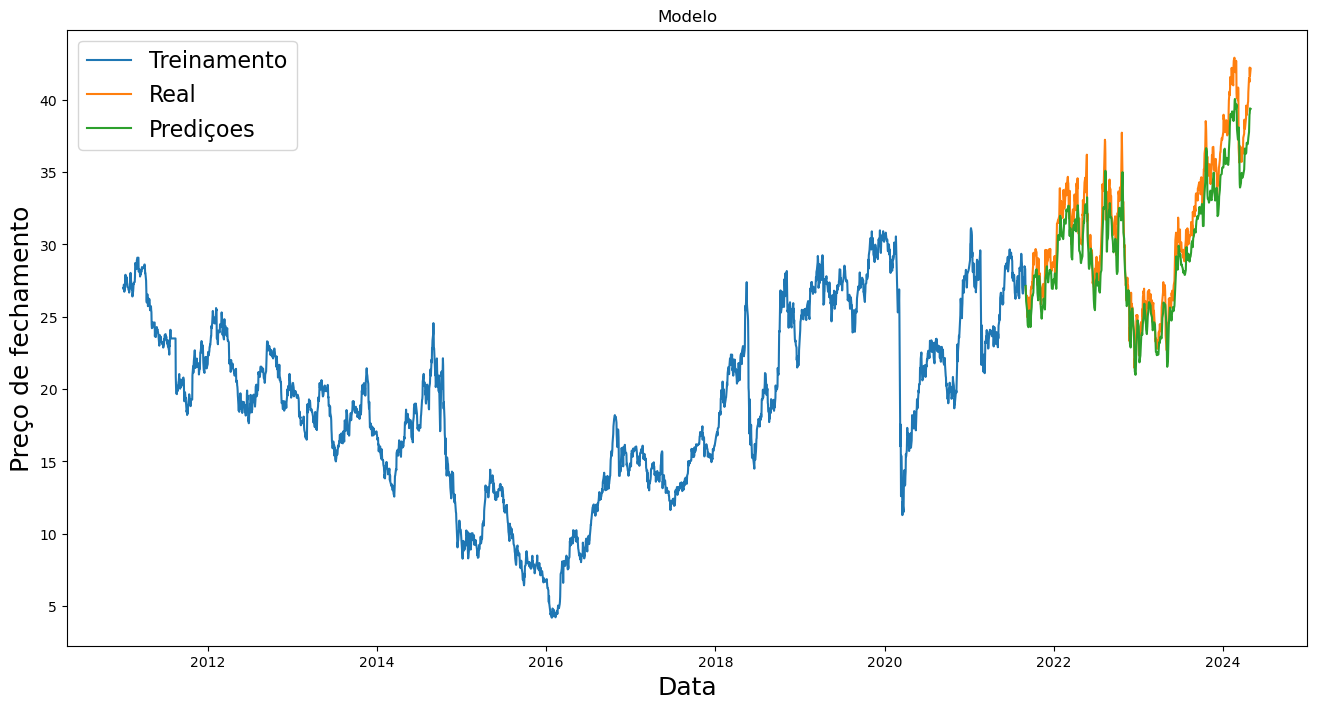

In [88]:
plt.figure(figsize = (16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Preço de fechamento', fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Prediçoes'], loc=2, prop={'size': 16})
plt.show()

In [89]:
df_teste.sort_index()

df_teste

,Close,predicoes
Date,,
2021-09-01,27.040001,27.127939
2021-09-02,26.600000,26.648975
2021-09-03,26.330000,26.080717
2021-09-06,26.459999,25.569643
2021-09-08,24.969999,25.306620
...,...,...
2024-04-23,41.419998,38.491943
2024-04-24,41.230000,38.971687
2024-04-25,42.220001,39.070362


In [90]:
#o preço é legal, mas o importante e acertar pra qual lado vai o mercado
#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero'], True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

,Close,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2021-09-02,26.600000,26.648975,-0.016272,-0.017656,False,False,True,0.016272
2021-09-03,26.330000,26.080717,-0.010150,-0.021324,False,False,True,0.010150
2021-09-06,26.459999,25.569643,0.004937,-0.019596,True,False,False,0.004937
2021-09-08,24.969999,25.306620,-0.056311,-0.010287,False,False,True,0.056311
2021-09-09,25.500000,24.695536,0.021225,-0.024147,True,False,False,0.021225
...,...,...,...,...,...,...,...,...
2024-04-23,41.419998,38.491943,-0.001928,0.019042,False,True,False,0.001928
2024-04-24,41.230000,38.971687,-0.004587,0.012463,False,True,False,0.004587
2024-04-25,42.220001,39.070362,0.024012,0.002532,True,True,True,0.024012


In [91]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print(acertou_lado)
print(exp_mat_lucro * 100)

acertou_o_lado
False    0.016941
True     0.018442
Name: variacao_percentual_acao_abs, dtype: float64
1.0886014986896697
0.5007564296520424
0.0777265593501093


In [92]:
#criando um codigo que voce passa 60 dias e ele devolve a cotacao
#resumindo: vamos descobrir o da petrobras de hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quise escolher um dia, basta fazer assim
data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:

    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)

else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)

cotacoes = yf.download(acao, start=inicio, end=final)
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalados = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalados)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[34.225433]]
